### 과제
주가 종목 선택 후 2005-01-01 ~ 2022-02-28(학습- 검증데이터)까지 데이터 분석 후 , (상승/하락 예측)
2022-03-01 ~ 2022-03-18(테스트 데이터) 이후의 데이터 정확도 확인
1. 일요일까지 제출하기

In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader.data as data
from matplotlib import pyplot as plt
%matplotlib inline

from datetime import datetime
from datetime import timedelta

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense
from tensorflow.keras.layers import Dropout, Flatten, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam

import tensorflow as tf

### 데이터 수집

In [ ]:
start = '2005-01-01'
end = '2022-03-18'

df = data.DataReader('AMZN.US', 'stooq', start, end)
df.to_csv('AMZN.csv')

In [ ]:
df = pd.read_csv('AMZN.csv')
df

,Date,Open,High,Low,Close,Volume
0,2022-03-18,3136.26,3231.88,3120.22,3225.01,5148138.0
1,2022-03-17,3052.81,3149.97,3042.80,3144.78,3646742.0
2,2022-03-16,2970.00,3063.00,2947.07,3062.08,4247884.0
3,2022-03-15,2857.00,2959.70,2840.00,2947.33,3779230.0
4,2022-03-14,2919.62,2949.00,2817.68,2837.06,3704305.0
...,...,...,...,...,...,...
4328,2005-01-07,41.30,42.69,41.16,42.32,9861972.0
4329,2005-01-06,41.85,42.25,40.90,41.05,8703006.0
4330,2005-01-05,41.57,42.76,41.56,41.77,8354707.0
4331,2005-01-04,42.62,43.26,41.50,42.14,19507792.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4333 entries, 0 to 4332
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4333 non-null   object 
 1   Open    4333 non-null   float64
 2   High    4333 non-null   float64
 3   Low     4333 non-null   float64
 4   Close   4333 non-null   float64
 5   Volume  4332 non-null   float64
dtypes: float64(5), object(1)
memory usage: 203.2+ KB


# 데이터 전처리

In [ ]:
# datetime 자료형으로 변경
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4333 entries, 0 to 4332
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4333 non-null   datetime64[ns]
 1   Open    4333 non-null   float64       
 2   High    4333 non-null   float64       
 3   Low     4333 non-null   float64       
 4   Close   4333 non-null   float64       
 5   Volume  4332 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 203.2 KB


In [ ]:
# 요일정보 추가 (월:0, 화:1, 수:2, 목:3, 금:4, 토:5, 일:6)
df['weekday'] = df['Date'].dt.weekday
df

,Date,Open,High,Low,Close,Volume,weekday
0,2022-03-18,3136.26,3231.88,3120.22,3225.01,5148138.0,4
1,2022-03-17,3052.81,3149.97,3042.80,3144.78,3646742.0,3
2,2022-03-16,2970.00,3063.00,2947.07,3062.08,4247884.0,2
3,2022-03-15,2857.00,2959.70,2840.00,2947.33,3779230.0,1
4,2022-03-14,2919.62,2949.00,2817.68,2837.06,3704305.0,0
...,...,...,...,...,...,...,...
4328,2005-01-07,41.30,42.69,41.16,42.32,9861972.0,4
4329,2005-01-06,41.85,42.25,40.90,41.05,8703006.0,3
4330,2005-01-05,41.57,42.76,41.56,41.77,8354707.0,2
4331,2005-01-04,42.62,43.26,41.50,42.14,19507792.0,1


In [ ]:
start = datetime(2005, 2, 25)
df['weeks'] = (df['Date'] - start) // timedelta(weeks=1)
df

,Date,Open,High,Low,Close,Volume,weekday,weeks
0,2022-03-18,3136.26,3231.88,3120.22,3225.01,5148138.0,4,890
1,2022-03-17,3052.81,3149.97,3042.80,3144.78,3646742.0,3,889
2,2022-03-16,2970.00,3063.00,2947.07,3062.08,4247884.0,2,889
3,2022-03-15,2857.00,2959.70,2840.00,2947.33,3779230.0,1,889
4,2022-03-14,2919.62,2949.00,2817.68,2837.06,3704305.0,0,889
...,...,...,...,...,...,...,...,...
4328,2005-01-07,41.30,42.69,41.16,42.32,9861972.0,4,-7
4329,2005-01-06,41.85,42.25,40.90,41.05,8703006.0,3,-8
4330,2005-01-05,41.57,42.76,41.56,41.77,8354707.0,2,-8
4331,2005-01-04,42.62,43.26,41.50,42.14,19507792.0,1,-8


In [ ]:
df = df[['Date', 'weeks', 'weekday', 'High', 'Low', 'Open', 'Close']]
df

,Date,weeks,weekday,High,Low,Open,Close
0,2022-03-18,890,4,3231.88,3120.22,3136.26,3225.01
1,2022-03-17,889,3,3149.97,3042.80,3052.81,3144.78
2,2022-03-16,889,2,3063.00,2947.07,2970.00,3062.08
3,2022-03-15,889,1,2959.70,2840.00,2857.00,2947.33
4,2022-03-14,889,0,2949.00,2817.68,2919.62,2837.06
...,...,...,...,...,...,...,...
4328,2005-01-07,-7,4,42.69,41.16,41.30,42.32
4329,2005-01-06,-8,3,42.25,40.90,41.85,41.05
4330,2005-01-05,-8,2,42.76,41.56,41.57,41.77
4331,2005-01-04,-8,1,43.26,41.50,42.62,42.14


In [ ]:
# 가장 오래된 날짜를 먼저 표시되도록 정렬 
df.sort_values(by='Date', ascending=True, inplace=True)
df

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Date,weeks,weekday,High,Low,Open,Close
4332,2005-01-03,-8,0,45.44,44.21,45.00,44.52
4331,2005-01-04,-8,1,43.26,41.50,42.62,42.14
4330,2005-01-05,-8,2,42.76,41.56,41.57,41.77
4329,2005-01-06,-8,3,42.25,40.90,41.85,41.05
4328,2005-01-07,-7,4,42.69,41.16,41.30,42.32
...,...,...,...,...,...,...,...
4,2022-03-14,889,0,2949.00,2817.68,2919.62,2837.06
3,2022-03-15,889,1,2959.70,2840.00,2857.00,2947.33
2,2022-03-16,889,2,3063.00,2947.07,2970.00,3062.08
1,2022-03-17,889,3,3149.97,3042.80,3052.81,3144.78


In [ ]:
# Date컬럼을 인덱스로 변경 (set_index)
df.set_index(keys='Date', inplace=True)
df

,weeks,weekday,High,Low,Open,Close
Date,,,,,,
2005-01-03,-8,0,45.44,44.21,45.00,44.52
2005-01-04,-8,1,43.26,41.50,42.62,42.14
2005-01-05,-8,2,42.76,41.56,41.57,41.77
2005-01-06,-8,3,42.25,40.90,41.85,41.05
2005-01-07,-7,4,42.69,41.16,41.30,42.32
...,...,...,...,...,...,...
2022-03-14,889,0,2949.00,2817.68,2919.62,2837.06
2022-03-15,889,1,2959.70,2840.00,2857.00,2947.33
2022-03-16,889,2,3063.00,2947.07,2970.00,3062.08


In [ ]:
# 다음달의 종가하고 당일의 종가하고의 차를 계산하여 새로운 컬럼으로 추가
df_shift = df.shift(-1)
df_shift

,weeks,weekday,High,Low,Open,Close
Date,,,,,,
2005-01-03,-8.0,1.0,43.26,41.50,42.62,42.14
2005-01-04,-8.0,2.0,42.76,41.56,41.57,41.77
2005-01-05,-8.0,3.0,42.25,40.90,41.85,41.05
2005-01-06,-7.0,4.0,42.69,41.16,41.30,42.32
2005-01-07,-7.0,0.0,42.96,41.71,41.86,41.84
...,...,...,...,...,...,...
2022-03-14,889.0,1.0,2959.70,2840.00,2857.00,2947.33
2022-03-15,889.0,2.0,3063.00,2947.07,2970.00,3062.08
2022-03-16,889.0,3.0,3149.97,3042.80,3052.81,3144.78


In [ ]:
df['Gap_close'] = df_shift['Close'] - df['Close']
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,weeks,weekday,High,Low,Open,Close,Gap_close
Date,,,,,,,
2005-01-03,-8,0,45.44,44.21,45.00,44.52,-2.38
2005-01-04,-8,1,43.26,41.50,42.62,42.14,-0.37
2005-01-05,-8,2,42.76,41.56,41.57,41.77,-0.72
2005-01-06,-8,3,42.25,40.90,41.85,41.05,1.27
2005-01-07,-7,4,42.69,41.16,41.30,42.32,-0.48
...,...,...,...,...,...,...,...
2022-03-14,889,0,2949.00,2817.68,2919.62,2837.06,110.27
2022-03-15,889,1,2959.70,2840.00,2857.00,2947.33,114.75
2022-03-16,889,2,3063.00,2947.07,2970.00,3062.08,82.70


In [ ]:
# 새로운컬럼 Up을 추가하고, 올라갈경우 1, 내려갈경우 0
# Gap_close 삭제
df['Up'] = 0
df['Up'][df['Gap_close'] > 0] = 1
df.drop('Gap_close', axis=1, inplace=True)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,weeks,weekday,High,Low,Open,Close,Up
Date,,,,,,,
2005-01-03,-8,0,45.44,44.21,45.00,44.52,0
2005-01-04,-8,1,43.26,41.50,42.62,42.14,0
2005-01-05,-8,2,42.76,41.56,41.57,41.77,0
2005-01-06,-8,3,42.25,40.90,41.85,41.05,1
2005-01-07,-7,4,42.69,41.16,41.30,42.32,0
...,...,...,...,...,...,...,...
2022-03-14,889,0,2949.00,2817.68,2919.62,2837.06,1
2022-03-15,889,1,2959.70,2840.00,2857.00,2947.33,1
2022-03-16,889,2,3063.00,2947.07,2970.00,3062.08,1


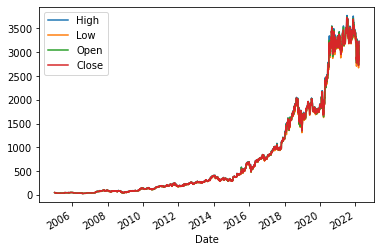

In [ ]:
# High, Low, Open, Close -> line graph로 그려보기 
df_new = df[['High','Low','Open','Close']]
df_new.plot(kind='line')

In [ ]:
df_shift = df.shift(1)
df_shift

,weeks,weekday,High,Low,Open,Close,Up
Date,,,,,,,
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,-8.0,0.0,45.44,44.21,45.00,44.52,0.0
2005-01-05,-8.0,1.0,43.26,41.50,42.62,42.14,0.0
2005-01-06,-8.0,2.0,42.76,41.56,41.57,41.77,0.0
2005-01-07,-8.0,3.0,42.25,40.90,41.85,41.05,1.0
...,...,...,...,...,...,...,...
2022-03-14,889.0,4.0,2993.50,2907.38,2991.49,2910.49,0.0
2022-03-15,889.0,0.0,2949.00,2817.68,2919.62,2837.06,1.0
2022-03-16,889.0,1.0,2959.70,2840.00,2857.00,2947.33,1.0


In [ ]:
df['Close_ratio'] = (df['Close'] - df_shift['Close']) / df_shift['Close']
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio
Date,,,,,,,,
2005-01-03,-8,0,45.44,44.21,45.00,44.52,0,NaN
2005-01-04,-8,1,43.26,41.50,42.62,42.14,0,-0.053459
2005-01-05,-8,2,42.76,41.56,41.57,41.77,0,-0.008780
2005-01-06,-8,3,42.25,40.90,41.85,41.05,1,-0.017237
2005-01-07,-7,4,42.69,41.16,41.30,42.32,0,0.030938
...,...,...,...,...,...,...,...,...
2022-03-14,889,0,2949.00,2817.68,2919.62,2837.06,1,-0.025229
2022-03-15,889,1,2959.70,2840.00,2857.00,2947.33,1,0.038868
2022-03-16,889,2,3063.00,2947.07,2970.00,3062.08,1,0.038934


In [ ]:
df['Body'] = df['Open'] - df['Close']
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body
Date,,,,,,,,,
2005-01-03,-8,0,45.44,44.21,45.00,44.52,0,NaN,0.48
2005-01-04,-8,1,43.26,41.50,42.62,42.14,0,-0.053459,0.48
2005-01-05,-8,2,42.76,41.56,41.57,41.77,0,-0.008780,-0.20
2005-01-06,-8,3,42.25,40.90,41.85,41.05,1,-0.017237,0.80
2005-01-07,-7,4,42.69,41.16,41.30,42.32,0,0.030938,-1.02
...,...,...,...,...,...,...,...,...,...
2022-03-14,889,0,2949.00,2817.68,2919.62,2837.06,1,-0.025229,82.56
2022-03-15,889,1,2959.70,2840.00,2857.00,2947.33,1,0.038868,-90.33
2022-03-16,889,2,3063.00,2947.07,2970.00,3062.08,1,0.038934,-92.08


# 주가 예측을 위한 LSTM 모델 작성

In [ ]:
list_weeks = []
list_weeks = df['weeks'].unique()
list_weeks

array([ -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,
         5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 17

In [ ]:
# 각 주별로 일수가 몇일씩인지 확인 
df['week_days'] = 0
for i in list_weeks:
    df['week_days'][df['weeks'] == i] = len(df[df['weeks'] == i])

df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body,week_days
Date,,,,,,,,,,
2005-01-03,-8,0,45.44,44.21,45.00,44.52,0,NaN,0.48,4
2005-01-04,-8,1,43.26,41.50,42.62,42.14,0,-0.053459,0.48,4
2005-01-05,-8,2,42.76,41.56,41.57,41.77,0,-0.008780,-0.20,4
2005-01-06,-8,3,42.25,40.90,41.85,41.05,1,-0.017237,0.80,4
2005-01-07,-7,4,42.69,41.16,41.30,42.32,0,0.030938,-1.02,5
...,...,...,...,...,...,...,...,...,...,...
2022-03-14,889,0,2949.00,2817.68,2919.62,2837.06,1,-0.025229,82.56,5
2022-03-15,889,1,2959.70,2840.00,2857.00,2947.33,1,0.038868,-90.33,5
2022-03-16,889,2,3063.00,2947.07,2970.00,3062.08,1,0.038934,-92.08,5


In [ ]:
# 주 5일인 데이터만 추출
df = df[df['week_days'] == 5]
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body,week_days
Date,,,,,,,,,,
2005-01-07,-7,4,42.69,41.16,41.30,42.32,0,0.030938,-1.02,5
2005-01-10,-7,0,42.96,41.71,41.86,41.84,0,-0.011342,0.02,5
2005-01-11,-7,1,42.16,41.01,41.40,41.64,1,-0.004780,-0.24,5
2005-01-12,-7,2,42.48,40.82,41.60,42.30,1,0.015850,-0.70,5
2005-01-13,-7,3,44.58,42.34,42.40,42.60,1,0.007092,-0.20,5
...,...,...,...,...,...,...,...,...,...,...
2022-03-11,889,4,2993.50,2907.38,2991.49,2910.49,0,-0.008807,81.00,5
2022-03-14,889,0,2949.00,2817.68,2919.62,2837.06,1,-0.025229,82.56,5
2022-03-15,889,1,2959.70,2840.00,2857.00,2947.33,1,0.038868,-90.33,5


In [ ]:
df = df[['weekday', 'High', 'Low', 'Open', 'Close', 'Close_ratio', 'Body', 'Up']]
df

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2005-01-07,4,42.69,41.16,41.30,42.32,0.030938,-1.02,0
2005-01-10,0,42.96,41.71,41.86,41.84,-0.011342,0.02,0
2005-01-11,1,42.16,41.01,41.40,41.64,-0.004780,-0.24,1
2005-01-12,2,42.48,40.82,41.60,42.30,0.015850,-0.70,1
2005-01-13,3,44.58,42.34,42.40,42.60,0.007092,-0.20,1
...,...,...,...,...,...,...,...,...
2022-03-11,4,2993.50,2907.38,2991.49,2910.49,-0.008807,81.00,0
2022-03-14,0,2949.00,2817.68,2919.62,2837.06,-0.025229,82.56,1
2022-03-15,1,2959.70,2840.00,2857.00,2947.33,0.038868,-90.33,1


# 학습 데이터와 검증 데이터 분리

In [ ]:
# 학습 데이터 (2005~2019) -> df_train
# 검증 데이터 (2020~2021) -> df_test
df_train = df['2005-02-01' : '2022-02-28']
df_train

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2005-02-01,1,43.270,42.38,43.00,42.48,-0.017122,0.52,0
2005-02-02,2,43.590,40.86,43.10,41.88,-0.014124,1.22,0
2005-02-03,3,35.890,34.53,34.90,35.75,-0.146371,-0.85,0
2005-02-04,4,35.980,35.19,35.64,35.72,-0.000839,-0.08,0
2005-02-07,0,35.840,35.55,35.75,35.69,-0.000840,0.06,1
...,...,...,...,...,...,...,...,...
2022-02-15,1,3160.140,3092.75,3152.11,3130.21,0.008658,21.90,1
2022-02-16,2,3176.680,3094.69,3115.81,3162.01,0.010159,-46.20,0
2022-02-17,3,3206.975,3090.00,3162.92,3093.05,-0.021809,69.87,0


In [ ]:
df_test = df['2022-03-01' : ]
df_test

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2022-03-01,1,3081.980,2999.54,3054.65,3022.84,-0.015766,31.81,1
2022-03-02,2,3059.990,2975.00,3018.15,3041.05,0.006024,-22.90,0
2022-03-03,3,3078.580,2937.12,3070.63,2957.97,-0.027320,112.66,0
2022-03-04,4,2957.000,2876.14,2943.18,2912.82,-0.015264,30.36,0
2022-03-07,0,2921.890,2748.33,2908.87,2749.06,-0.056220,159.81,0
2022-03-08,1,2813.990,2671.45,2733.67,2720.29,-0.010465,13.38,1
2022-03-09,2,2805.000,2736.56,2790.00,2785.58,0.024001,4.42,1
2022-03-10,3,2973.485,2879.56,2913.70,2936.35,0.054125,-22.65,0
2022-03-11,4,2993.500,2907.38,2991.49,2910.49,-0.008807,81.00,0


In [ ]:
X_train = df_train[['weekday','High','Low','Open','Close','Close_ratio','Body']]
y_train = df_train['Up']

print(X_train)
print(y_train)

            weekday      High      Low     Open    Close  Close_ratio   Body
Date                                                                        
2005-02-01        1    43.270    42.38    43.00    42.48    -0.017122   0.52
2005-02-02        2    43.590    40.86    43.10    41.88    -0.014124   1.22
2005-02-03        3    35.890    34.53    34.90    35.75    -0.146371  -0.85
2005-02-04        4    35.980    35.19    35.64    35.72    -0.000839  -0.08
2005-02-07        0    35.840    35.55    35.75    35.69    -0.000840   0.06
...             ...       ...      ...      ...      ...          ...    ...
2022-02-15        1  3160.140  3092.75  3152.11  3130.21     0.008658  21.90
2022-02-16        2  3176.680  3094.69  3115.81  3162.01     0.010159 -46.20
2022-02-17        3  3206.975  3090.00  3162.92  3093.05    -0.021809  69.87
2022-02-25        4  3079.800  2984.27  3011.00  3075.77     0.016058 -64.77
2022-02-28        0  3089.000  3017.00  3048.50  3071.26    -0.001466 -22.76

In [ ]:
X_test = df_test[['weekday','High','Low','Open','Close','Close_ratio','Body']]
y_test = df_test['Up']

print(X_test)
print(y_test)

            weekday      High      Low     Open    Close  Close_ratio    Body
Date                                                                         
2022-03-01        1  3081.980  2999.54  3054.65  3022.84    -0.015766   31.81
2022-03-02        2  3059.990  2975.00  3018.15  3041.05     0.006024  -22.90
2022-03-03        3  3078.580  2937.12  3070.63  2957.97    -0.027320  112.66
2022-03-04        4  2957.000  2876.14  2943.18  2912.82    -0.015264   30.36
2022-03-07        0  2921.890  2748.33  2908.87  2749.06    -0.056220  159.81
2022-03-08        1  2813.990  2671.45  2733.67  2720.29    -0.010465   13.38
2022-03-09        2  2805.000  2736.56  2790.00  2785.58     0.024001    4.42
2022-03-10        3  2973.485  2879.56  2913.70  2936.35     0.054125  -22.65
2022-03-11        4  2993.500  2907.38  2991.49  2910.49    -0.008807   81.00
2022-03-14        0  2949.000  2817.68  2919.62  2837.06    -0.025229   82.56
2022-03-15        1  2959.700  2840.00  2857.00  2947.33     0.0

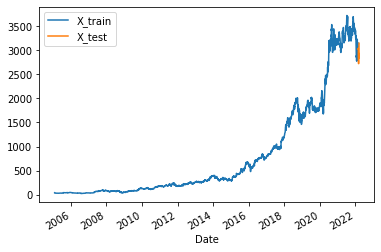

<Figure size 1440x1080 with 0 Axes>

In [ ]:
X_train['Close'].plot(kind='line')
X_test['Close'].plot(kind='line')

plt.legend(['X_train', 'X_test'])
plt.figure(figsize=(20,15))
plt.show()

In [ ]:
# 학습 데이터, 정답 데이터 -> 월~목(4일씩)까지 1set 
# LSTM -> Numpy 배열 
# StandardScaler 사용
def Scaler_to_np(df):
    df_list = []
    df = np.array(df) 
    for i in range(0, len(df) - 3, 4): 
        df_s = df[i : i + 4] 
        scaler = StandardScaler()
        df_scaler = scaler.fit_transform(df_s)
        df_list.append(df_scaler)
    
    return np.array(df_list)

In [ ]:
X_train_array = Scaler_to_np(X_train)
X_test_array = Scaler_to_np(X_test)

print(X_train_array.shape)
print(X_test_array.shape)

(921, 4, 7)
(3, 4, 7)


In [ ]:
y_train_new = y_train[3::4]
y_test_new = y_test[3::4]
print(len(y_train_new))
print(len(y_test_new))

921
3


## LSTM 모델 생성

In [ ]:
# from keras.layers import LeakyReLU

In [ ]:
def gen_lstm_compile(df):
    model = Sequential()
    model.add(LSTM(256, activation='relu', batch_input_shape=(None, df.shape[1], df.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='elu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    return model

In [ ]:
# 시계열데이터 모델검증하기 (Timeseries Validation) -> TimeSeriesSpilt
valid_scores = [] # 4번의 교차 검증의 결과 저장 
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
for fold, (train_indices, value_indices) in enumerate(tscv.split(X_train_array)):
    X_train, X_valid = X_train_array[train_indices], X_train_array[value_indices]
    y_train, y_valid = y_train_new[train_indices], y_train_new[value_indices]
    
    model = gen_lstm_compile(X_train)
    model.fit(X_train, y_train, epochs=50, batch_size=64)
    
    y_pred = model.predict(X_valid)
    
    y_pred = np.where(y_pred < 0.5, 0, 1)
    
    score = accuracy_score(y_valid, y_pred)
    print(f"fold {fold} Score: {score}")
    
    valid_scores.append(score)

Epoch 1/50
3/3 [==============================] - 2s 21ms/step - loss: 0.6950 - accuracy: 0.4808
Epoch 2/50
3/3 [==============================] - 0s 20ms/step - loss: 0.6944 - accuracy: 0.4487
Epoch 3/50
3/3 [==============================] - 0s 19ms/step - loss: 0.6927 - accuracy: 0.5000
Epoch 4/50
3/3 [==============================] - 0s 18ms/step - loss: 0.6951 - accuracy: 0.4808
Epoch 5/50
3/3 [==============================] - 0s 20ms/step - loss: 0.6954 - accuracy: 0.4487
Epoch 6/50
3/3 [==============================] - 0s 22ms/step - loss: 0.6947 - accuracy: 0.4808
Epoch 7/50
3/3 [==============================] - 0s 19ms/step - loss: 0.6938 - accuracy: 0.4744
Epoch 8/50
3/3 [==============================] - 0s 19ms/step - loss: 0.6914 - accuracy: 0.5577
Epoch 9/50
3/3 [==============================] - 0s 19ms/step - loss: 0.6942 - accuracy: 0.4936
Epoch 10/50
3/3 [==============================] - 0s 18ms/step - loss: 0.6904 - accuracy: 0.5641
Epoch 11/50
3/3 [============

In [ ]:
print(f"valid_scores: {valid_scores}")
cv_score = np.mean(valid_scores)
print(f"cv_score: {cv_score}")

valid_scores: [0.49019607843137253, 0.47058823529411764, 0.48366013071895425, 0.43137254901960786, 0.5163398692810458]
cv_score: 0.4784313725490196


In [ ]:
model = gen_lstm_compile(X_train_array)
r = model.fit(X_train_array, y_train_new, epochs=50, batch_size=64)

Epoch 1/50
15/15 [==============================] - 2s 20ms/step - loss: 0.6946 - accuracy: 0.4940
Epoch 2/50
15/15 [==============================] - 0s 20ms/step - loss: 0.6942 - accuracy: 0.4788
Epoch 3/50
15/15 [==============================] - 0s 20ms/step - loss: 0.6949 - accuracy: 0.4495
Epoch 4/50
15/15 [==============================] - 0s 22ms/step - loss: 0.6936 - accuracy: 0.4962
Epoch 5/50
15/15 [==============================] - 0s 20ms/step - loss: 0.6947 - accuracy: 0.4723
Epoch 6/50
15/15 [==============================] - 0s 20ms/step - loss: 0.6946 - accuracy: 0.4767
Epoch 7/50
15/15 [==============================] - 0s 19ms/step - loss: 0.6944 - accuracy: 0.4821
Epoch 8/50
15/15 [==============================] - 0s 19ms/step - loss: 0.6957 - accuracy: 0.4539
Epoch 9/50
15/15 [==============================] - 0s 20ms/step - loss: 0.6943 - accuracy: 0.4843
Epoch 10/50
15/15 [==============================] - 0s 19ms/step - loss: 0.6946 - accuracy: 0.4756
Epoch 11/

In [ ]:
X_test_array

array([[[-1.34164079,  0.73504997,  1.13004075,  0.67153898,
          0.76426665, -0.22297683, -0.12746728],
        [-0.4472136 ,  0.30507727,  0.60273138, -0.07128011,
          1.11957162,  1.58700338, -1.25727442],
        [ 0.4472136 ,  0.66856943, -0.21122458,  0.99675128,
         -0.50144633, -1.18272146,  1.54215268],
        [ 1.34164079, -1.70869667, -1.52154755, -1.59701015,
         -1.38239193, -0.18130509, -0.15741098]],

       [[-1.34164079,  0.60528693, -0.14094358,  0.93481406,
         -0.58563635, -1.43894367,  1.70168442],
        [-0.4472136 , -0.90308132, -1.15886204, -1.33014824,
         -0.93118101, -0.32455115, -0.35644434],
        [ 0.4472136 , -1.02875537, -0.29678255, -0.60192149,
         -0.14700962,  0.51490231, -0.48238052],
        [ 1.34164079,  1.32654976,  1.59658817,  0.99725566,
          1.66382697,  1.24859251, -0.86285956]],

       [[ 1.52127766,  0.04939899,  0.56699302,  1.09951816,
         -0.35373781, -0.6915588 ,  0.99093638],
      

In [ ]:
pred = model.predict(X_test_array)
pred[:10]

array([[0.49932376],
       [0.50729096],
       [0.50657815]], dtype=float32)

In [ ]:
pred = np.where(pred < 0.5, 0, 1)
pred[:10]

array([[0],
       [1],
       [1]])

In [ ]:
print(f"accuracy= {accuracy_score(y_true=y_test_new, y_pred=pred)}")

accuracy= 0.6666666666666666


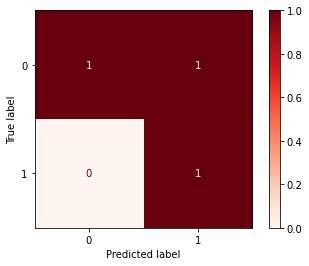

In [ ]:
cm = confusion_matrix(y_test_new, pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)